# Part 3: Trip Distribution 
    Choose approach to conduct trip distribution step for the future transportation demand, prepare data for this step and implement it. 

In [39]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import logit
import statsmodels.api as sm
import scipy as sp
import geopandas as gpd
from shapely import wkt

In [40]:
#### Store the url string that hosts our .csv files 
#### Copy data files to the 2022CMS folder that should be in the same folder as this notebook
urlday = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Day_2022.csv"
urlhhl = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Household_2022.csv"
urlper = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Person_2022.csv"
urlzon = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Survey_Zones.csv"
urltrp = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Trip_2022.csv"
urlveh = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Vehicle_2022.csv"

#### Read the .csv file using `pandas` libriary and store it as a `pandas` Data Frame
dday = pd.read_csv(urlday)
dhhl = pd.read_csv(urlhhl)
dper = pd.read_csv(urlper)
dzon = pd.read_csv(urlzon)
dtrp = pd.read_csv(urltrp)
dveh = pd.read_csv(urlveh)

#### Finally, let's make sure that all columns are displayed
pd.set_option('display.max_columns', None)

## Step I: Creating distance table

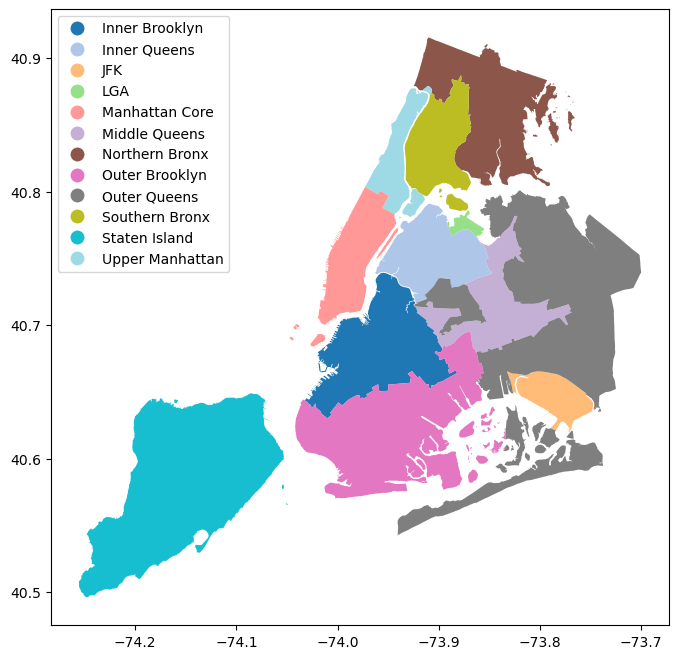

In [47]:
dzon["geometry"] = dzon["Shape"].apply(wkt.loads)

gdf = gpd.GeoDataFrame(dzon, geometry="geometry", crs="EPSG:4326")
gdf.plot(column="CMS Zone", legend=True, legend_kwds={'loc':'upper left'}, figsize=(8, 8),cmap='tab20')
plt.show()

In [ ]:
gdf_proj = gdf.to_crs(epsg=2263)
gdf_proj['centroid'] = gdf_proj.geometry.centroid

n_zones = 12
distance_matrix = pd.DataFrame(index=gdf_proj['CMS Zone'], columns=gdf_proj['CMS Zone'], dtype=float)

for i in range(n_zones):
    for j in range(n_zones):
        distance_matrix.iloc[i,j] = np.maximum(gdf_proj['centroid'].iloc[i].distance(gdf_proj['centroid'].iloc[j])//1000, 1)

display(distance_matrix)

CMS Zone,Middle Queens,Inner Brooklyn,Northern Bronx,Outer Brooklyn,LGA,Inner Queens,JFK,Outer Queens,Upper Manhattan,Southern Bronx,Manhattan Core,Staten Island
CMS Zone,,,,,,,,,,,,
Middle Queens,1.0,33.0,53.0,43.0,23.0,21.0,29.0,15.0,47.0,46.0,40.0,98.0
Inner Brooklyn,33.0,1.0,72.0,22.0,41.0,29.0,49.0,46.0,52.0,58.0,26.0,65.0
Northern Bronx,53.0,72.0,1.0,91.0,32.0,42.0,80.0,60.0,28.0,16.0,54.0,132.0
Outer Brooklyn,43.0,22.0,91.0,1.0,58.0,48.0,43.0,49.0,73.0,78.0,48.0,60.0
LGA,23.0,41.0,32.0,58.0,1.0,11.0,52.0,34.0,25.0,23.0,31.0,104.0
Inner Queens,21.0,29.0,42.0,48.0,11.0,1.0,50.0,36.0,27.0,29.0,21.0,93.0
JFK,29.0,49.0,80.0,43.0,52.0,50.0,1.0,19.0,77.0,75.0,66.0,104.0
Outer Queens,15.0,46.0,60.0,49.0,34.0,36.0,19.0,1.0,60.0,57.0,55.0,108.0
Upper Manhattan,47.0,52.0,28.0,73.0,25.0,27.0,77.0,60.0,1.0,11.0,29.0,106.0


In [ ]:
zone_nums = list(range(12))
zone_names = {k: v for k, v in enumerate(dzon['CMS Zone'])}

dtrp['o_cms_zone_name'] = dtrp['o_cms_zone'].map(zone_names)
dtrp['d_cms_zone_name'] = dtrp['d_cms_zone'].map(zone_names)

tripzone_d = dtrp.groupby('d_cms_zone_name').size()
tripzone_o = dtrp.groupby('o_cms_zone_name').size()

all_zones = set(zone_names.values())
o_zones_with_data = set(tripzone_o.index)
d_zones_with_data = set(tripzone_d.index)

missing_origins = all_zones - o_zones_with_data
missing_destinations = all_zones - d_zones_with_data

print("Origin zones with no trips:", missing_origins)
print("Destination zones with no trips:", missing_destinations)

tripzone_o = tripzone_o.reindex(all_zones, fill_value=0)
tripzone_d = tripzone_d.reindex(all_zones, fill_value=0)

tripzone = pd.crosstab(dtrp['o_cms_zone_name'], dtrp['d_cms_zone_name'])
tripzone = tripzone.reindex(index=all_zones, columns=all_zones, fill_value=0)

print(f"Number of trips from each origin zone:\n{tripzone_o}\n")
print(f"Number of trips to each destination zone:\n{tripzone_d}\n")

Origin zones with no trips: {'Middle Queens'}
Destination zones with no trips: {'Middle Queens'}
Number of trips from each origin zone:
o_cms_zone_name
Outer Queens        4776
Middle Queens          0
Inner Queens        7223
Southern Bronx      5081
JFK                 4798
LGA                20783
Inner Brooklyn      5127
Northern Bronx      6774
Outer Brooklyn      7462
Staten Island       8072
Upper Manhattan    11395
Manhattan Core      4848
dtype: int64

Number of trips to each destination zone:
d_cms_zone_name
Outer Queens        4750
Middle Queens          0
Inner Queens        7215
Southern Bronx      5050
JFK                 4778
LGA                20903
Inner Brooklyn      5147
Northern Bronx      6743
Outer Brooklyn      7403
Staten Island       8166
Upper Manhattan    11358
Manhattan Core      4826
dtype: int64



## Step II: Forecast the future trip

In [ ]:
np.random.seed(50664004)

future_tripzone_o = {}
future_tripzone_d = {}

for zone in tripzone_o.index:
    future_tripzone_o[zone] = max(0, int(tripzone_o[zone]*(1+np.random.uniform(-0.1, 0.1))))

for zone in tripzone_d.index:
    future_tripzone_d[zone] = max(0, int(tripzone_d[zone]*(1+np.random.uniform(-0.1, 0.1))))

print(f'Future Destination Trips Destribution:\n{future_tripzone_d}')
print(f'Future Origin Trips Destribution:\n{future_tripzone_o}')

Future Destination Trips Destribution:
{'Outer Queens': 4880, 'Middle Queens': 0, 'Inner Queens': 6532, 'Southern Bronx': 4717, 'JFK': 4647, 'LGA': 20615, 'Inner Brooklyn': 5515, 'Northern Bronx': 6331, 'Outer Brooklyn': 7835, 'Staten Island': 7541, 'Upper Manhattan': 10260, 'Manhattan Core': 4769}
Future Origin Trips Destribution:
{'Outer Queens': 5232, 'Middle Queens': 0, 'Inner Queens': 7718, 'Southern Bronx': 5152, 'JFK': 4467, 'LGA': 22295, 'Inner Brooklyn': 5492, 'Northern Bronx': 6789, 'Outer Brooklyn': 7098, 'Staten Island': 8186, 'Upper Manhattan': 10667, 'Manhattan Core': 4793}


In [ ]:
f_origin = np.array(list(future_tripzone_o.values()))
f_dest = np.array(list(future_tripzone_o.values()))

dist = distance_matrix.to_numpy()

# Define a deterrence function based on an exponential decay 
beta_impedance_function = 0.1
def deterrence_function(cij, beta):
    return np.exp(-beta * cij)
deter = deterrence_function(dist, beta_impedance_function)

## Step III: Trips distribution using Gravity Model

In [ ]:
def gravity_model(
    O: np.ndarray,
    D: np.ndarray,
    cost_matrix: np.ndarray,
    deterrence_matrix: np.ndarray,
    error_threshold: float = 0.01,
    improvement_threshold: float = 1e-4,
    max_iterations: int = 1000,
    verbose: bool = True,
):
    # Input validation
    O, D = np.asarray(O, dtype=float), np.asarray(D, dtype=float)
    n = len(O)
    
    # Normalize O and D to have equal sums
    sum_O, sum_D = O.sum(), D.sum()
    if not np.isclose(sum_O, sum_D):
        scale = max(sum_O, sum_D) / min(sum_O, sum_D)
        if sum_O < sum_D:
            O = O * scale
        else:
            D = D * scale
    
    T = O.sum()
    
    if verbose:
        print_matrix(cost_matrix, "Initial Cost Matrix")
        print_matrix(deterrence_matrix, "Deterrence Matrix")
    
    # Initialize balancing factors
    Ai, Bj = np.ones(n), np.ones(n)
    prev_error = np.inf
    eps = 1e-9  # Prevent division by zero
    
    for iteration in range(1, max_iterations + 1):
        # Vectorized update of balancing factors
        Ai = 1.0 / (deterrence_matrix @ (Bj * D) + eps)
        Bj_new = 1.0 / (deterrence_matrix.T @ (Ai * O) + eps)
        
        # Compute trip matrix using outer product
        Tij = np.outer(Ai * O, Bj_new * D) * deterrence_matrix
        
        # Calculate error
        error = (np.abs(O - Tij.sum(axis=1)).sum() + 
                 np.abs(D - Tij.sum(axis=0)).sum()) / T
        
        # Check stopping conditions
        if error < error_threshold:
            stop_reason = "Error threshold met"
            break
        if abs(prev_error - error) < improvement_threshold:
            stop_reason = "Slow improvement"
            break
            
        prev_error, Bj = error, Bj_new
    else:
        stop_reason = "Max iterations reached"
    
    # Build result DataFrame
    zone_labels = [f"Zone {i}" for i in range(1, n + 1)]
    result = pd.DataFrame(Tij, columns=zone_labels, index=zone_labels)
    result["Origin"] = result.sum(axis=1)
    result.loc["Destination"] = result.sum()
    result = result.round(3)
    
    if verbose:
        print("Final OD Matrix:")
        print(result, "\n")
        print(f"Iterations: {iteration} | Stop: {stop_reason} | Error: {error*100:.3f}%")
    
    return result


def print_matrix(matrix: np.ndarray, name: str):
    n = matrix.shape[0]
    labels = [f"Zone {i}" for i in range(1, n + 1)]
    df = pd.DataFrame(matrix, columns=labels, index=labels)
    print(f"{name}:\n{df}\n")

In [ ]:
solution_gravity_model = gravity_model(
    f_origin,  # Origin matrix
    f_dest,  # Destination matrix
    dist,  # Cost matrix
    deter,  # Deterrence matrix
    error_threshold = 0.01,  # Error threshold for stopping condition
    improvement_threshold = 1e-4)  # Improvement threshold for stopping condition

Initial Cost Matrix:
          Zone 1  Zone 2  Zone 3  Zone 4  Zone 5  Zone 6  Zone 7  Zone 8  \
Zone 1      1.0    33.0    53.0    43.0    23.0    21.0    29.0    15.0   
Zone 2     33.0     1.0    72.0    22.0    41.0    29.0    49.0    46.0   
Zone 3     53.0    72.0     1.0    91.0    32.0    42.0    80.0    60.0   
Zone 4     43.0    22.0    91.0     1.0    58.0    48.0    43.0    49.0   
Zone 5     23.0    41.0    32.0    58.0     1.0    11.0    52.0    34.0   
Zone 6     21.0    29.0    42.0    48.0    11.0     1.0    50.0    36.0   
Zone 7     29.0    49.0    80.0    43.0    52.0    50.0     1.0    19.0   
Zone 8     15.0    46.0    60.0    49.0    34.0    36.0    19.0     1.0   
Zone 9     47.0    52.0    28.0    73.0    25.0    27.0    77.0    60.0   
Zone 10    46.0    58.0    16.0    78.0    23.0    29.0    75.0    57.0   
Zone 11    40.0    26.0    54.0    48.0    31.0    21.0    66.0    55.0   
Zone 12    98.0    65.0   132.0    60.0   104.0    93.0   104.0   108.0   

  

## Trip Distribution Results Discussion

    How future distribution is different compared to trip distribution in 2022? Provide at least 1 graph to support your discussion.


In [87]:
display(solution_gravity_model.sum(), tripzone.sum())


Zone 1      10464.000
Zone 2          0.000
Zone 3      15435.999
Zone 4      10303.999
Zone 5       8934.000
Zone 6      44589.999
Zone 7      10984.001
Zone 8      13578.001
Zone 9      14196.002
Zone 10     16372.000
Zone 11     21334.001
Zone 12      9586.001
Origin     175777.999
dtype: float64

d_cms_zone_name
Outer Queens        4750
Middle Queens          0
Inner Queens        7215
Southern Bronx      5050
JFK                 4778
LGA                20903
Inner Brooklyn      5147
Northern Bronx      6743
Outer Brooklyn      7403
Staten Island       8166
Upper Manhattan    11358
Manhattan Core      4826
dtype: int64

d_cms_zone_name,Outer Queens,Middle Queens,Inner Queens,Southern Bronx,JFK,LGA,Inner Brooklyn,Northern Bronx,Outer Brooklyn,Staten Island,Upper Manhattan,Manhattan Core
o_cms_zone_name,,,,,,,,,,,,
Outer Queens,3199,0,229,73,611,114,28,29,23,368,94,8
Middle Queens,0,0,0,0,0,0,0,0,0,0,0,0
Inner Queens,218,0,5226,26,344,861,14,43,69,190,209,23
Southern Bronx,76,0,30,3787,38,246,1,19,14,108,674,88
JFK,587,0,333,30,3012,427,15,15,17,203,155,4
LGA,136,0,835,239,367,15355,268,408,1329,495,1170,181
Inner Brooklyn,30,0,15,2,15,236,3702,505,231,355,34,2
Northern Bronx,26,0,49,13,15,420,498,5151,351,194,53,4
Outer Brooklyn,15,0,84,6,18,1405,230,336,5041,255,70,2


,Outer Queens,Middle Queens,Inner Queens,Southern Bronx,JFK,LGA,Inner Brooklyn,Northern Bronx,Outer Brooklyn,Staten Island,Upper Manhattan,Manhattan Core
Outer Queens,2755.360,0.0,23.121,43.817,235.006,952.415,195.445,854.426,35.069,40.873,101.915,0.132
Middle Queens,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Inner Queens,21.367,0.0,5891.687,0.507,134.310,163.947,1.675,13.343,329.590,1154.017,35.328,0.006
Southern Bronx,69.030,0.0,0.864,4881.747,11.856,106.937,80.521,47.640,4.352,2.783,76.507,9.833
JFK,213.752,0.0,132.193,6.845,1484.926,1812.590,13.719,89.473,221.588,285.423,175.502,0.051
LGA,860.314,0.0,160.252,61.314,1800.112,16236.151,55.217,241.392,597.827,516.180,1572.048,0.501
Inner Brooklyn,229.995,0.0,2.133,60.146,17.750,71.934,4411.764,786.177,2.397,3.087,10.391,0.099
Northern Bronx,922.576,0.0,15.590,32.651,106.216,288.550,721.364,4704.598,12.977,18.473,30.877,0.066
Outer Brooklyn,31.685,0.0,322.241,2.496,220.116,597.974,1.840,10.859,3991.226,1548.447,350.264,0.068
Staten Island,37.182,0.0,1136.003,1.607,285.467,519.838,2.386,15.564,1559.037,4469.257,151.208,0.026


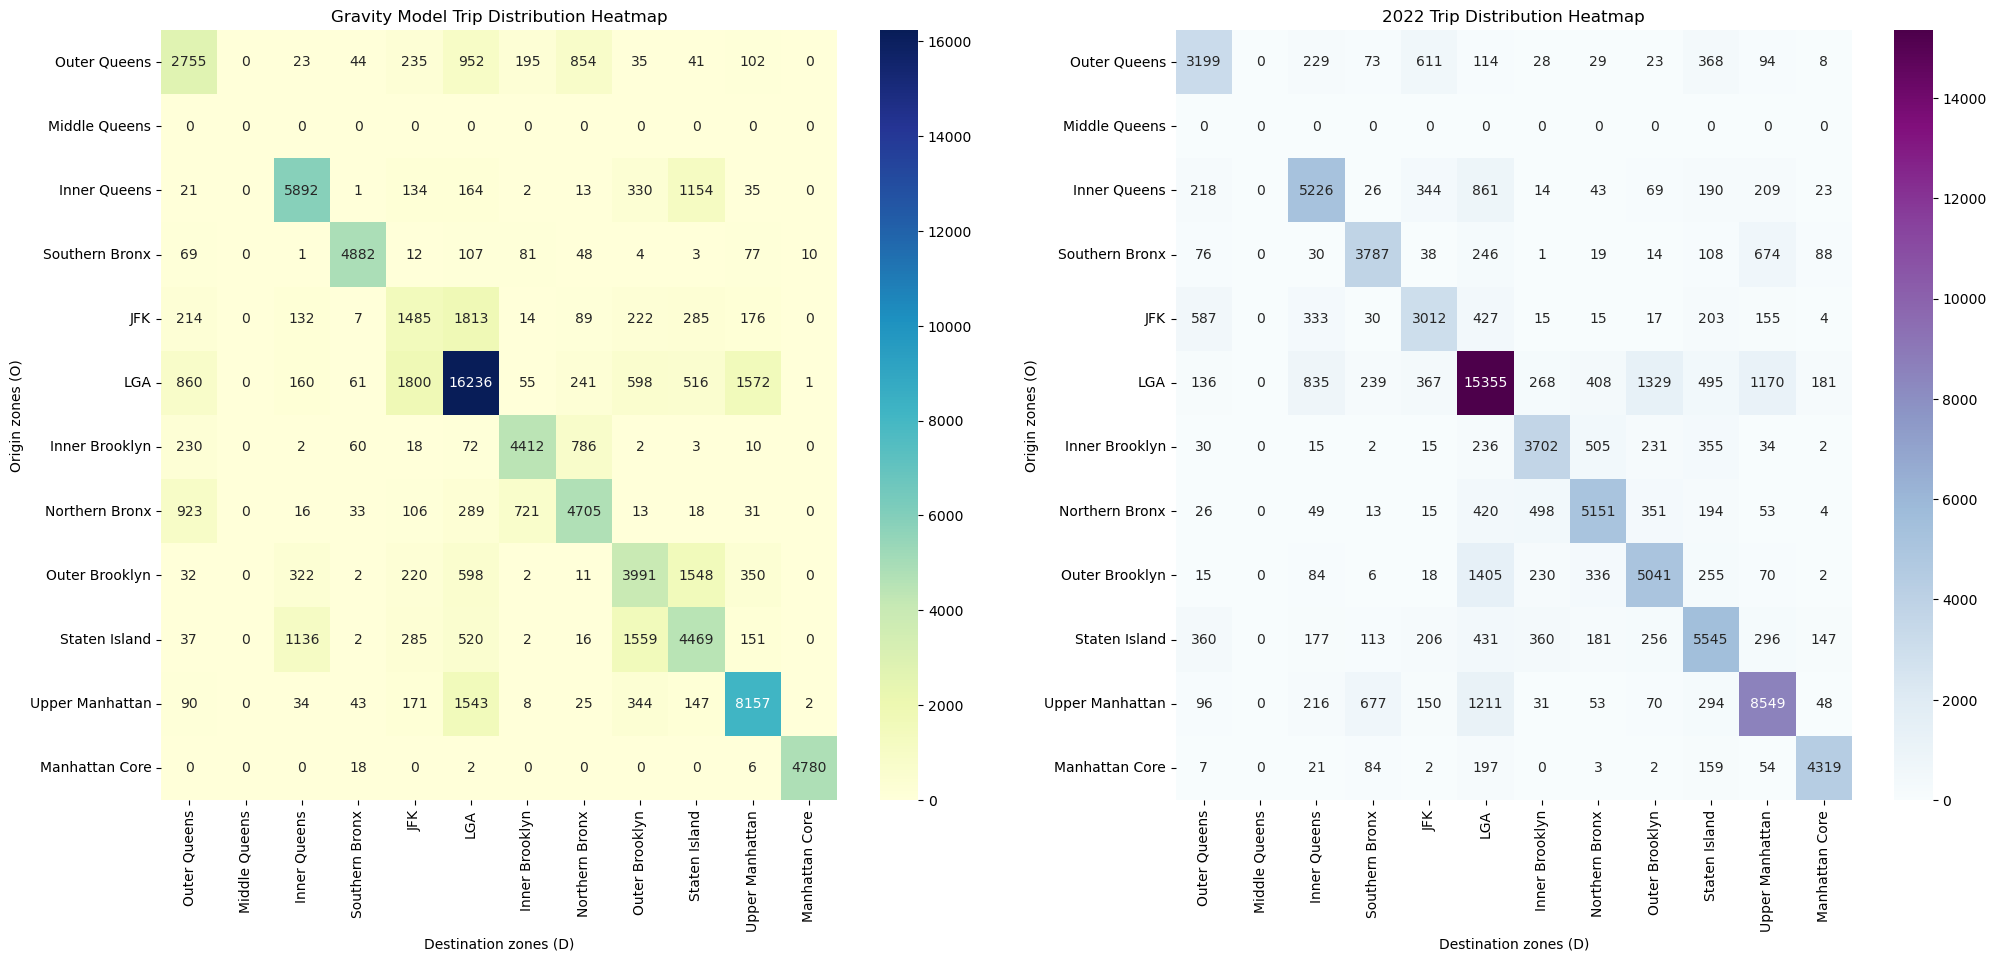

In [ ]:
zone_names_list = tripzone_o.index.tolist()

solution_gravity_model_copy = solution_gravity_model.copy()
solution_gravity_model_copy.drop(columns=['Origin'], inplace=True)
solution_gravity_model_copy.drop(index=['Destination'], inplace=True)

zone_mapping = {f"Zone {i+1}": zone_names_list[i] for i in range(len(zone_names_list))}
solution_gravity_model_renamed = solution_gravity_model_copy.rename(columns=zone_mapping, index=zone_mapping)

solution_gravity_model_renamed

plt.figure(figsize=(24,10))
plt.subplot(1, 2, 1)
sns.heatmap(solution_gravity_model_renamed, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Gravity Model Trip Distribution Heatmap")
plt.xlabel('Destination zones (D)')
plt.ylabel('Origin zones (O)')

display(tripzone, solution_gravity_model_renamed)
plt.subplot(1, 2, 2)
heatmap = sns.heatmap(tripzone, annot=True, fmt="d", cmap="BuPu")
plt.title("2022 Trip Distribution Heatmap")
plt.xlabel('Destination zones (D)')
plt.ylabel('Origin zones (O)')
plt.show()

,Outer Queens,Middle Queens,Inner Queens,Southern Bronx,JFK,LGA,Inner Brooklyn,Northern Bronx,Outer Brooklyn,Staten Island,Upper Manhattan,Manhattan Core
Outer Queens,-443.640,0.0,-205.879,-29.183,-375.994,838.415,167.445,825.426,12.069,-327.127,7.915,-7.868
Middle Queens,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Inner Queens,-196.633,0.0,665.687,-25.493,-209.690,-697.053,-12.325,-29.657,260.590,964.017,-173.672,-22.994
Southern Bronx,-6.970,0.0,-29.136,1094.747,-26.144,-139.063,79.521,28.640,-9.648,-105.217,-597.493,-78.167
JFK,-373.248,0.0,-200.807,-23.155,-1527.074,1385.590,-1.281,74.473,204.588,82.423,20.502,-3.949
LGA,724.314,0.0,-674.748,-177.686,1433.112,881.151,-212.783,-166.608,-731.173,21.180,402.048,-180.499
Inner Brooklyn,199.995,0.0,-12.867,58.146,2.750,-164.066,709.764,281.177,-228.603,-351.913,-23.609,-1.901
Northern Bronx,896.576,0.0,-33.410,19.651,91.216,-131.450,223.364,-446.402,-338.023,-175.527,-22.123,-3.934
Outer Brooklyn,16.685,0.0,238.241,-3.504,202.116,-807.026,-228.160,-325.141,-1049.774,1293.447,280.264,-1.932
Staten Island,-322.818,0.0,959.003,-111.393,79.467,88.838,-357.614,-165.436,1303.037,-1075.743,-144.792,-146.974


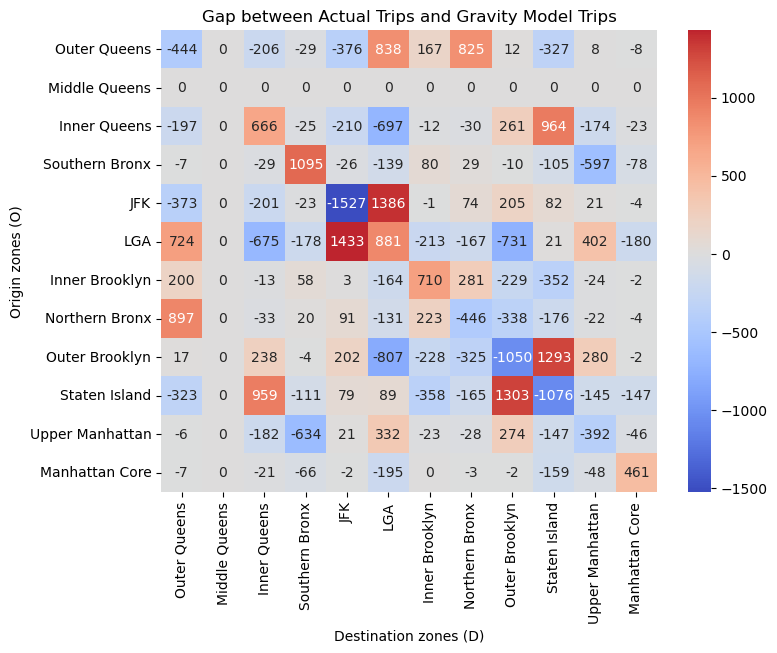

In [ ]:
gap_trips = solution_gravity_model_renamed - tripzone

display(gap_trips)

plt.figure(figsize=(8,6))
sns.heatmap(gap_trips, annot=True, fmt=".0f", cmap="coolwarm", center=0)
plt.title("Gap between Actual Trips and Gravity Model Trips")
plt.xlabel('Destination zones (D)') 
plt.ylabel('Origin zones (O)')
plt.show()

In [69]:
gap_trips_o = gap_trips.sum()
gap_trips_d = gap_trips.sum(axis=1)
display(gap_trips_o, gap_trips_d)

Outer Queens        482.000
Middle Queens         0.000
Inner Queens        502.999
Southern Bronx      101.999
JFK                -311.000
LGA                1391.999
Inner Brooklyn      345.001
Northern Bronx       46.001
Outer Brooklyn     -304.998
Staten Island        20.000
Upper Manhattan    -690.999
Manhattan Core      -32.999
dtype: float64

Outer Queens        461.579
Middle Queens         0.000
Inner Queens        522.777
Southern Bronx      211.070
JFK                -361.938
LGA                1318.308
Inner Brooklyn      468.873
Northern Bronx       79.938
Outer Brooklyn     -384.784
Staten Island       105.575
Upper Manhattan    -830.138
Manhattan Core      -41.257
dtype: float64

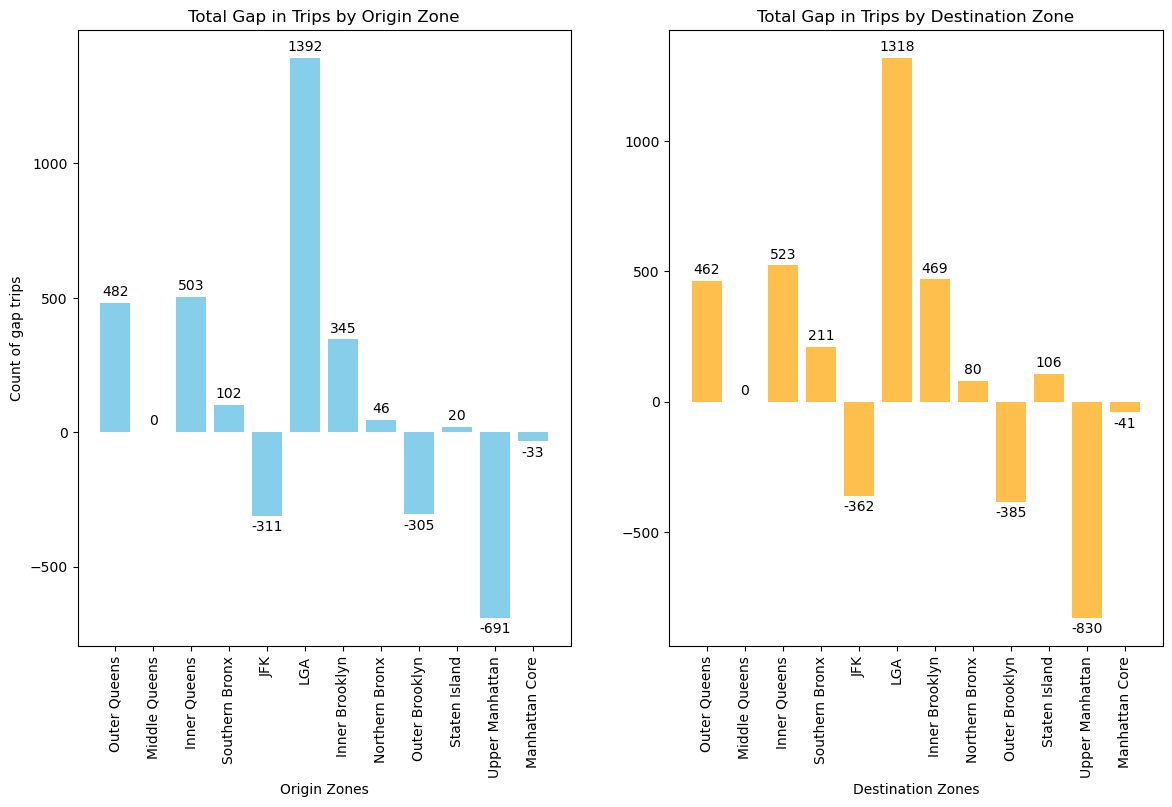

In [85]:
plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)
o_bar = plt.bar(gap_trips_o.index, gap_trips_o.values, color='skyblue')
plt.bar_label(o_bar,fmt="{:.0f}",padding=3)
plt.title("Total Gap in Trips by Origin Zone")
plt.xlabel('Origin Zones')
plt.ylabel('Count of gap trips')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
o_bar = plt.bar(gap_trips_d.index, gap_trips_d.values, color='orange',alpha=0.7)
plt.bar_label(o_bar,fmt="{:.0f}",padding=3)
plt.title("Total Gap in Trips by Destination Zone")
plt.xlabel('Destination Zones')
plt.xticks(rotation=90)
plt.show()

From the figures above, it is clear that the number of trips estimated using the GM method shows a slight increase compared to the original trips, which depends on the forecasting approach used in Step 2. In terms of trip distribution, the figures show that most travel trips decrease, particularly between the two zones with the longest distances. The concentration of decreases in the two distant zones indicates that travelers are less likely to make long trips in the forecast scenario. Overall, the trip distribution pattern remains similar to the original. These results highlight the importance of carefully selecting forecasting methods, as they can influence the allocation of future trips.